In [10]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [11]:
# 데이터 불러오기(드라이브 마운트)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# 이미지 경로를 데이터 프레임 형태로 만드는 함수
dir_ = Path('/content/drive/MyDrive/sampledata2')
filepaths = list(dir_.glob(r'**/*.png'))
print(len(filepaths))

def proc_img(filepath):
  # 이미지데이터의 경로와 label 데이터로 데이터프레임 만들기
  labels = [str(filepath[i]).split("/")[-2] \
            for i in range(len(filepath))]
  filepath = pd.Series(filepath, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  # 경로와 라벨 합치기
  df = pd.concat([filepath, labels], axis=1)

  # index 재설정
  df = df.sample(frac=1, random_state=0).reset_index(drop = True)

  return df

# dataframe 구조 확인
df = proc_img(filepaths)
df.head(5)

1699


,Filepath,Label
0,/content/drive/MyDrive/sampledata2/abnormal/22...,abnormal
1,/content/drive/MyDrive/sampledata2/abnormal/21...,abnormal
2,/content/drive/MyDrive/sampledata2/abnormal/21...,abnormal
3,/content/drive/MyDrive/sampledata2/normal/444.png,normal
4,/content/drive/MyDrive/sampledata2/abnormal/22...,abnormal


In [13]:
# 데이터 확인
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1699

Number of different labels: 2

Labels: ['abnormal' 'normal']


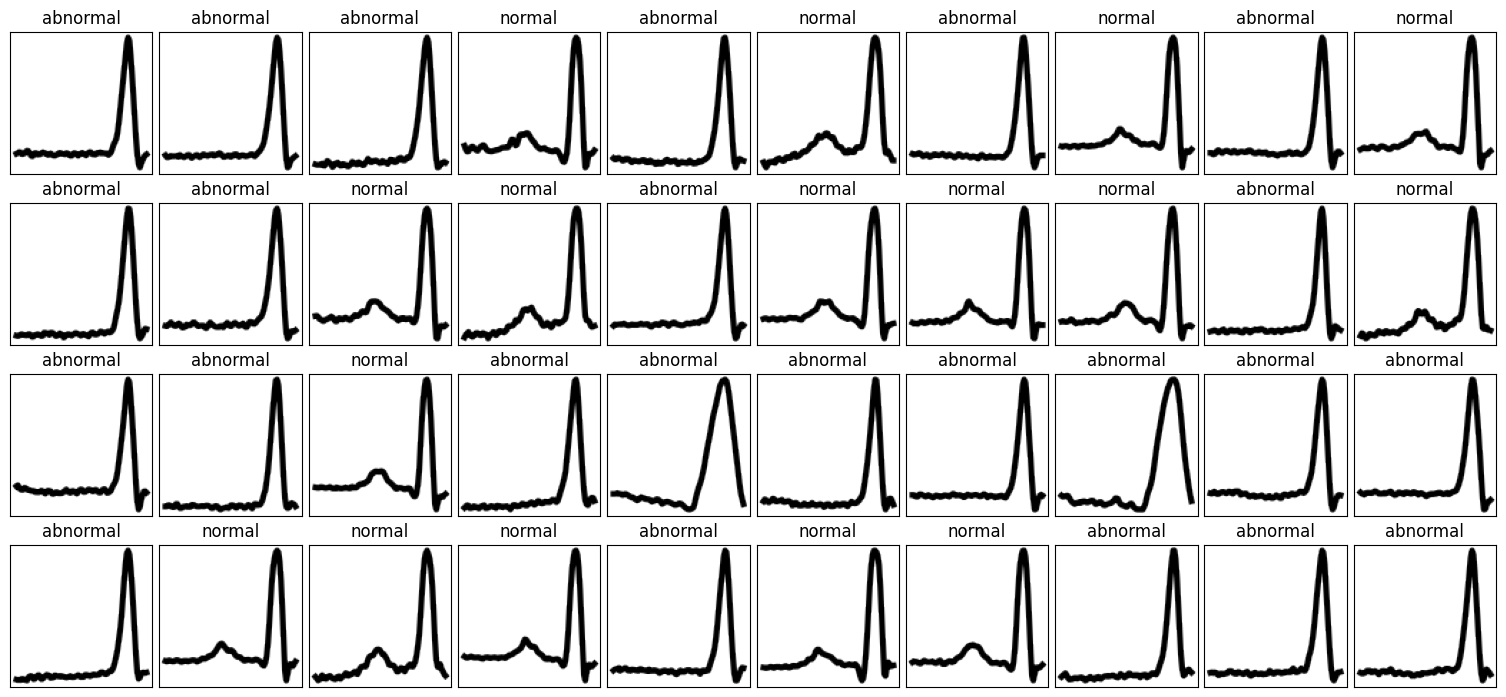

In [14]:
# 이미지 데이터 확인 1
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.Filepath[i]))
  ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

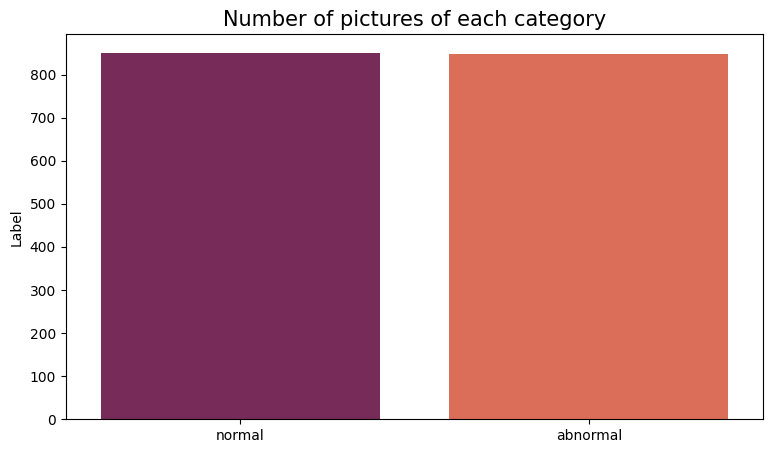

In [15]:
# 이미지 데이터 확인 2
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x=vc.index, y = vc, palette = 'rocket')
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [16]:
# 이미지 데이터 train, test 데이터로 분류
# training/test split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)
train_df.shape, test_df.shape

((1529, 2), (170, 2))

In [17]:
# 코랩에서 자동 생성되는 파일(checkpoints) 지우는 코드
!rmdir /content/drive/MyDrive/sampledata2/.ipynb_checkpoints/

rmdir: failed to remove '/content/drive/MyDrive/sampledata2/.ipynb_checkpoints/': No such file or directory


In [18]:
# base model 전처리
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)
# flow_from_directory()는 인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라고 간주하고
# 그 레이블이라고 간주한 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측하여
# Numpy Array Iterator를 생성
# target_size = 사용할 CNN 모델 입력 사이즈에 맞게 resize
train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/sampledata2',
                                              target_size=(100, 100),
                                              batch_size = 32,
                                              class_mode = 'categorical', subset='training')
val_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/sampledata2',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical', subset='validation')

Found 1360 images belonging to 2 classes.
Found 339 images belonging to 2 classes.


In [19]:
# train, test, val data generator
# 이미지 로드 함수 정의
def create_gen():

  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
      validation_split=0.1
  )

  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
  )

  train_images = train_generator.flow_from_dataframe(
      dataframe=train_df,
      x_col='Filepath', # 파일 위치 열이름
      y_col='Label', # 클래스 열이름
      target_size=(100,100), # 이미지 사이즈
      color_mode="rgb",
      class_mode='categorical',
      batch_size=32,
      shuffle=True,
      seed=0,
      subset='training'
  )

  val_images = train_generator.flow_from_dataframe(
      dataframe=train_df,
      x_col='Filepath', # 파일 위치 열이름
      y_col='Label', # 클래스 열이름
      target_size=(100,100), # 이미지 사이즈
      color_mode="rgb",
      class_mode='categorical',
      batch_size=32,
      shuffle=True,
      seed=0,
      subset='validation'
  )

  test_images = test_generator.flow_from_dataframe(
      dataframe=test_df,
      x_col='Filepath', # 파일 위치 열이름
      y_col='Label', # 클래스 열이름
      target_size=(100,100), # 이미지 사이즈
      color_mode="rgb",
      class_mode='categorical',
      batch_size=32,
      shuffle=False,
  )

  return train_generator, test_generator, train_images, val_images, test_images

In [20]:
# 이미지 로드 함수 실행
train_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 1377 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.


In [21]:
# 딥러닝 CNN 모델로 베이스라인 모델링
# CNN 초기화
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[100, 100, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [22]:
# 모델 학습
history = cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
43/43 [==============================] - 211s 5s/step - loss: 0.2399 - accuracy: 0.9265 - val_loss: 0.0510 - val_accuracy: 0.9882
Epoch 2/10
43/43 [==============================] - 27s 638ms/step - loss: 0.0020 - accuracy: 0.9985 - val_loss: 0.0356 - val_accuracy: 0.9912
Epoch 3/10
43/43 [==============================] - 22s 501ms/step - loss: 2.4038e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9912
Epoch 4/10
43/43 [==============================] - 23s 516ms/step - loss: 3.2001e-05 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9912
Epoch 5/10
43/43 [==============================] - 23s 520ms/step - loss: 2.6049e-05 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9912
Epoch 6/10
43/43 [==============================] - 21s 495ms/step - loss: 2.1008e-05 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9912
Epoch 7/10
43/43 [==============================] - 21s 486ms/step - loss: 1.7507e-05 - accuracy: 1.0000 - val_loss: 0.0537 - va

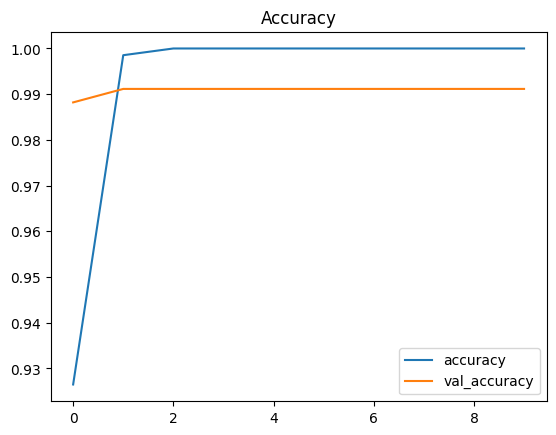

In [23]:
# 모델 성능 확인 - accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

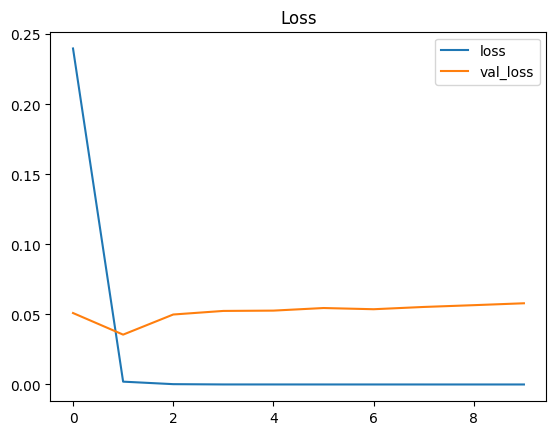

In [24]:
# 모델 성능 확인 - loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [25]:
# 모델 평가 - loss, accuracy
cnn.evaluate_generator(generator=val_gen)

<ipython-input-25-d328aee051d1>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  cnn.evaluate_generator(generator=val_gen)


[0.05798329785466194, 0.991150438785553]

In [26]:
# test 데이터로 모델 성능 예측
# predict the output
pred = cnn.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 1s 192ms/step
Accuracy on the test set: 99.41%


In [27]:
# TFlite로 변환하기 전의 모델 저장
cnn.save('my_model.h5')

In [28]:
# 변수로 저장되어 있는 모델을, TFLite 모델로 변환
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(cnn)

# FP16 양자화 설정
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 모델 양자화
tflite_model = converter.convert()

# 변환된 모델을 .tflite 파일에 저장
open("multiImageClassifier.tflite", "wb").write(tflite_model)

4359196